In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras import layers

def unet():
    inputs = keras.Input(shape=(None, None, 3))

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path
    up1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up1 = layers.concatenate([up1, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up2 = layers.concatenate([up2, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up3 = layers.concatenate([up3, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    return keras.Model(inputs=inputs, outputs=outputs)

In [4]:
optimizer = 'adam' # good for boundary detection; other options: RMSprop, SGD
loss = 'binary_crossentropy'
metrics = ['binary_accuracy'] # other options: binary_crossentropy
model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 64)       0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [5]:
weights_path = "/content/drive/MyDrive/workspace/ImageSegmentation_01/UNET/model/unet_final.h5"


In [6]:
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path)

#from keras.models import load_model
#model = load_model(weights_path)

Loading weights  /content/drive/MyDrive/workspace/ImageSegmentation_01/UNET/model/unet_final.h5


In [7]:
def resize_me_with_ratio(im , desired_size = 256):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_im

In [8]:
from google.colab.patches import cv2_imshow
# Load preprocessed test images
#test_input_dir = './data/test/'
image_path = "/content/drive/MyDrive/workspace/ImageSegmentation_01/UNET/data/test/63.png"
test_images = []

#for i in range(5):
#    image_filename = f"rescaled_preprocessed_image_{i}.png"
#    image_path = os.path.join(test_input_dir, image_filename)
#    image = cv2.imread(image_path)
#    cv2_imshow(image)
#    test_images.append(image)
image = cv2.imread(image_path)
dim = image.shape[:2]
#if dim != 256:
#  image = resize_me_with_ratio(image, 256)
test_images.append(image)
cv2_imshow(test_images[0])
# Normalize pixel values
test_images = np.array(test_images) / 255.0

Output hidden; open in https://colab.research.google.com to view.

In [9]:
predictions = model.predict(test_images)


1/1 [==============================] - 23s 23s/step


In [10]:
# Apply thresholding to convert predicted masks to binary images
def post_process(predictions, threshold=0.5):
    binary_images = (predictions > threshold).astype(np.uint8)
    return binary_images

processed_predictions = post_process(predictions, threshold=0.2)

In [11]:
def post_process_mask(binary_mask):

    # Perform morphological operations for boundary enhancement
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=5)
    eroded_mask = cv2.erode(dilated_mask, kernel, iterations=5)
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Further thresholding to obtain a clean binary mask
    #_, final_mask = cv2.threshold(eroded_mask, 127, 255, cv2.THRESH_BINARY)

    return closed_mask

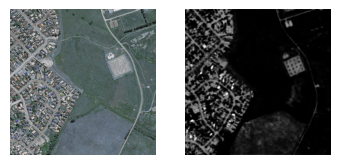

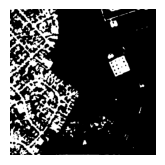

In [12]:
import matplotlib.pyplot as plt
plt.figure(3)
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predictions[0], cmap='gray')
plt.axis('off')
plt.show()

plt.subplot(1, 3, 3)
plt.imshow(processed_predictions[0], cmap='gray')
plt.axis('off')
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

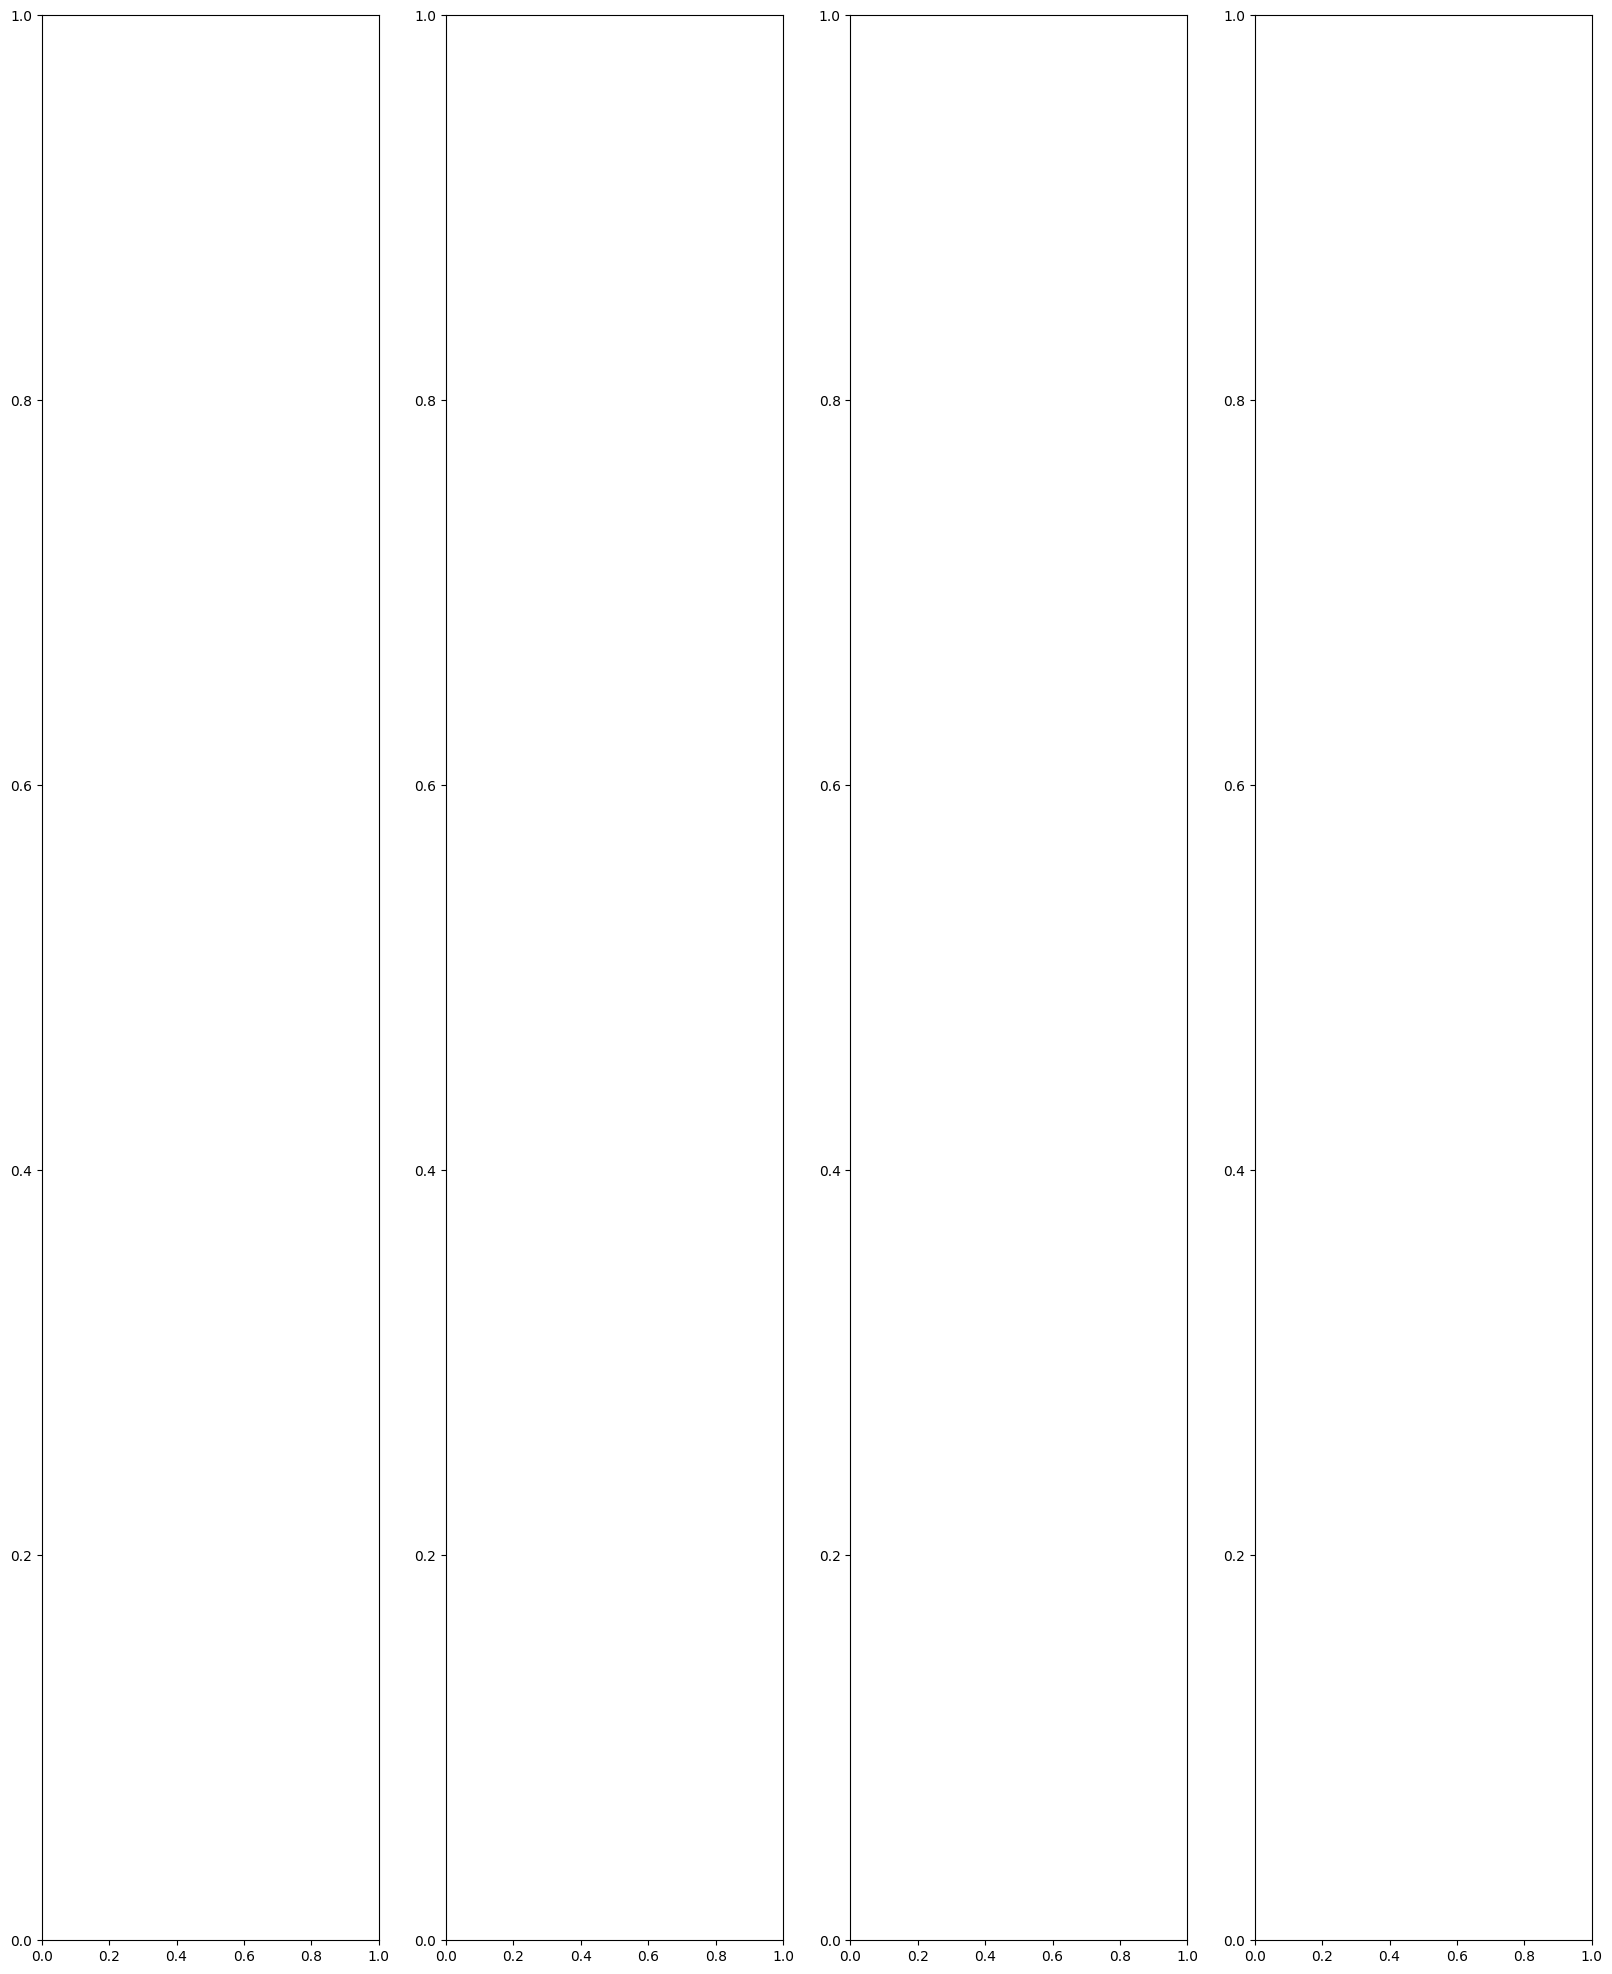

In [13]:
fig, axes = plt.subplots(len(test_images), 4, figsize=(20, 25))

for i in range(len(test_images)):

    # Display test image
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title('Test Image')
    axes[i, 0].axis('off')

    # Display prediction
    axes[i, 1].imshow(processed_predictions[i], cmap='gray')
    axes[i, 1].set_title('Binarised Prediction')
    axes[i, 1].axis('off')

    # Display prediction with post-processed mask
    axes[i, 2].imshow(post_process_mask(processed_predictions[i]), cmap='gray')
    axes[i, 2].set_title('Binarised Prediction with post-processed mask')
    axes[i, 2].axis('off')

    # Display prediction on top of test image
    axes[i, 3].imshow(test_images[i])
    axes[i, 3].imshow(post_process_mask(processed_predictions[i]), cmap='gray', alpha=0.4)
    axes[i, 3].set_title('Prediction on Image')
    axes[i, 3].axis('off')

plt.tight_layout()
#plt.savefig(root_dir + '/data/predictions/comparison.png')
plt.show()